In [1]:
import torch

from opal_ptx import build_kernel, kernel_transformer
import io
import base64

In [2]:
@kernel_transformer.kernel()
def game_of_life_next(currentFrame_: "u64", nextFrame_: "u64", width: "s32", height: "s32"):
    x: s32 = u32("%tid.x") + u32("%ntid.x") * u32("%ctaid.x")
    y: s32 = u32("%tid.y") + u32("%ntid.y") * u32("%ctaid.y")

    currentFrame: u64
    ptx.cvta.to._global.u64(currentFrame, currentFrame_)
    nextFrame: u64
    ptx.cvta.to._global.u64(nextFrame, nextFrame_)
    
    if (x >= width) | (y >= height):
        ptx.exit()
    
    liveNeighbors: u32 = 0
    for j in range(-1, 2, 1): # these are just regular python loops and the contents get inlined btw.
        for i in range(-1, 2, 1):
            if i == 0 and j == 0:
                continue
            nX:u32 = (x + s32(i) + width) % width
            nY:u32 = (y + s32(j) + height) % height

            nPtr: u64 = currentFrame + nX + nY * width 
            val: u32
            ptx.ld.u8._global(val, [nPtr])
            if val > 0:
                liveNeighbors += 1

    cPtr: u64 = currentFrame + y * width + x
    val: u32
    ptx.ld.u8._global(val, [cPtr])
    
    nextAlive: u32 = 0
    if val > 0:
        nextAlive = (liveNeighbors == 2) | (liveNeighbors == 3)
    else:
        nextAlive = liveNeighbors == 3
    
    nextPtr: u64 = nextFrame + (x + y * width) 
    val = (nextAlive & 1) * 255
    ptx.st.u8._global([nextPtr], val) 
    

game_of_life_next_ = build_kernel(game_of_life_next, debug=False)


KERNEL BUILDER DEBUG OUTPUT ENABLED



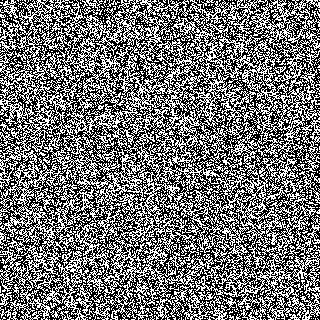

In [4]:
WIDTH = 32 * 10
HEIGHT = 32 * 10
currentFrame = ((torch.rand((HEIGHT, WIDTH), device="cuda") < 0.45).float() * 255).to(torch.uint8)

nextFrame = torch.zeros((HEIGHT, WIDTH), dtype=torch.uint8, device="cuda")
frames = [currentFrame.clone()]

for i in range(200):
    game_of_life_next_((WIDTH//32, HEIGHT//32, 1), (32, 32, 1), (currentFrame.data_ptr(), nextFrame.data_ptr(), WIDTH, HEIGHT), 0) 
    frames.append(nextFrame.clone())
    currentFrame = nextFrame
    nextFrame = torch.zeros((HEIGHT, WIDTH), dtype=torch.uint8, device="cuda")
    
frames = torch.stack(frames)

import numpy as np
from PIL import Image
from IPython.display import HTML

cpu_frames = frames.cpu().numpy()
cpu_frames = [Image.fromarray(frame.astype('uint8')) for frame in cpu_frames]
buffer = io.BytesIO()
cpu_frames[0].save(buffer, format='GIF', save_all=True, append_images=cpu_frames[1:], duration=100, loop=1)

gif_base64 = base64.b64encode(buffer.getvalue()).decode('utf-8')

from IPython.display import HTML
HTML(f'<img style="image-rendering: pixelated;" width="700px" height="700px" src="data:image/gif;base64,{gif_base64}">')